In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


In [29]:
sample_submission = pd.read_csv('/sample_submission.csv')
df_train = pd.read_csv('/train.csv')
df_test = pd.read_csv('/test.csv')

In [30]:
print(df_test.shape, df_train.shape)

(16656, 784) (16636, 785)


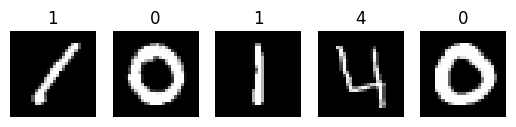

In [ ]:
# Plot 5 sample digits
fig, axes = plt.subplots(1, 5)
for i, ax in enumerate(axes):
    ax.imshow(df_train.iloc[i, 1:].to_numpy().reshape(28, 28), cmap='gray')
    ax.set_title(df_train.iloc[i, 0])
    ax.axis('off')
plt.show()

PreProcessing

In [31]:
from tensorflow.keras.utils import to_categorical  # type: ignore # One-hot encode

X = df_train.drop('label', axis=1).to_numpy()
y = df_train['label'].to_numpy()

# Normalize the pixel values  [0, 255] -> [0, 1]
X = X / 255.0

X = X.reshape(-1, 28, 28, 1)

y = to_categorical(y, 10)
y

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
#Build the CNN model

from tensorflow.keras import models, layers # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Flatten, Input # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D # type: ignore

# Define a model with convolutional layers
model_conv = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),  # First convolutional layer
    MaxPooling2D(pool_size=(2, 2)),                                             # Max pooling layer
    Conv2D(64, kernel_size=(3, 3), activation='relu'),                          # Second convolutional layer
    MaxPooling2D(pool_size=(2, 2)),                                             # Max pooling layer
    Flatten(),                                                                 # Flatten the output
    Dense(128, activation='relu'),                                              # Fully connected layer
    Dense(10, activation='softmax')                                              # Output layer
])


model_conv.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])


history_conv = model_conv.fit(X_train, y_train,
                              validation_data=(X_val, y_val),
                              epochs=2,
                              batch_size=32)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
416/416 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.5470 - loss: nan - val_accuracy: 0.0992 - val_loss: nan
Epoch 2/2
416/416 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.1005 - loss: nan - val_accuracy: 0.0992 - val_loss: nan


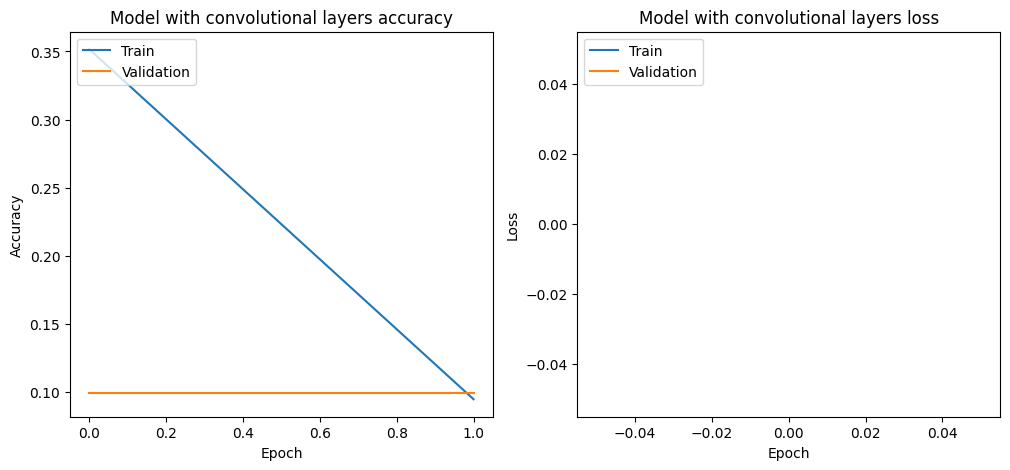

In [34]:
def history_plot(history, model_name='Model'):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left');


history_plot(history_conv, model_name='Model with convolutional layers')

In [35]:
from tensorflow.keras.layers import Dropout
# Define a model with dropout
model_dropout = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),  # First convolutional layer
    MaxPooling2D(pool_size=(2, 2)),                                             # Max pooling layer
    Dropout(0.25),                                                              # Dropout layer
    Conv2D(64, kernel_size=(3, 3), activation='relu'),                          # Second convolutional layer
    MaxPooling2D(pool_size=(2, 2)),                                             # Max pooling layer
    Dropout(0.25),                                                              # Dropout layer
    Flatten(),                                                                 # Flatten the output
    Dense(128, activation='relu'),                                              # Fully connected layer
    Dropout(0.5),                                                               # Dropout layer
    Dense(10, activation='softmax')                                              # Output layer
])

model_dropout.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

history_dropout = model_dropout.fit(X_train, y_train,
                                    validation_data=(X_train, y_train),
                                    epochs=2,
                                    batch_size=32)

Epoch 1/2
416/416 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.2437 - loss: nan - val_accuracy: 0.0945 - val_loss: nan
Epoch 2/2
416/416 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.0966 - loss: nan - val_accuracy: 0.0945 - val_loss: nan


In [37]:
!pip install keras-tuner --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.0 MB/s eta 0:00:00


In [38]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout

# Define the model creation function
def build_model(hp):
    model = Sequential([
        Input(shape=(28, 28, 1)),
        Conv2D(filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
               kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)),
        Conv2D(filters=hp.Int('conv_2_filters', min_value=64, max_value=256, step=64),
               kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)),
        Flatten(),
        Dense(units=hp.Int('dense_units', min_value=128, max_value=512, step=128), activation='relu'),
        Dropout(rate=hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [39]:
# Create the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=2,
    executions_per_trial=1,
    directory='my_dir1',
    project_name='intro_to_kt1'
)

tuner.search(X_train, y_train, epochs=2, validation_data=(X_val, y_val))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

best_model = tuner.hypermodel.build(best_hps)

print(f"Best hyperparameters: {best_hps}")

Trial 2 Complete [00h 01m 09s]
val_accuracy: 0.09915865212678909

Best val_accuracy So Far: 0.09915865212678909
Total elapsed time: 00h 02m 15s
Best hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7d08eeb5fa90>


In [40]:
history_best = best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=2)

Epoch 1/2
416/416 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.7565 - loss: nan - val_accuracy: 0.0992 - val_loss: nan
Epoch 2/2
416/416 ━━━━━━━━━━━━━━━━━━━━ 40s 53ms/step - accuracy: 0.0934 - loss: nan - val_accuracy: 0.0992 - val_loss: nan


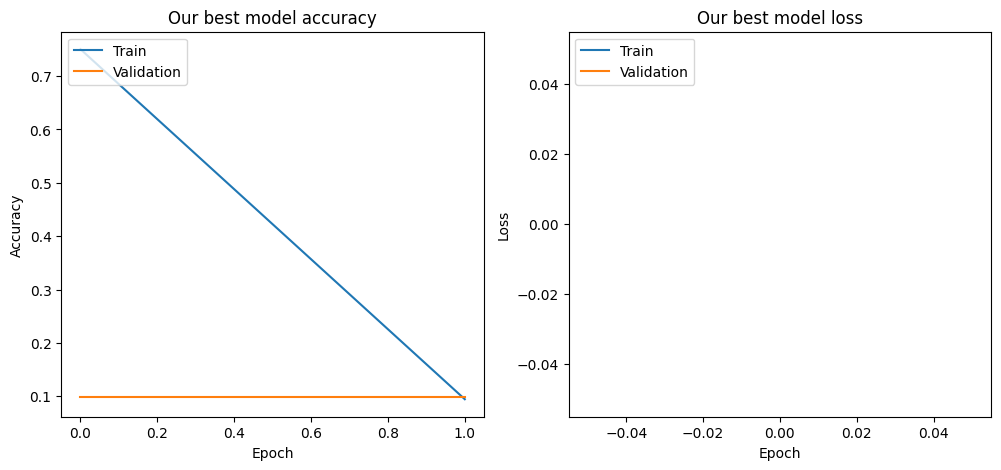

In [41]:
history_plot(history_best, model_name='Our best model')

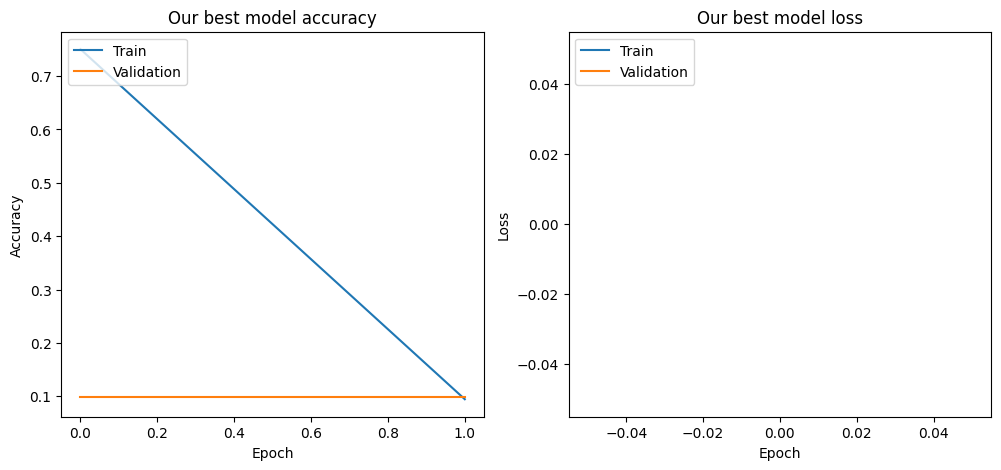

In [42]:
history_plot(history_best, model_name='Our best model')

In [43]:
y_val_pred = best_model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [44]:
cnn_test_loss, cnn_test_accuracy = best_model.evaluate(X_val, y_val, verbose=0)
print(f'Test Loss: {cnn_test_loss}')
print(f'Test Accuracy: {cnn_test_accuracy}')

Test Loss: nan
Test Accuracy: 0.09915865212678909


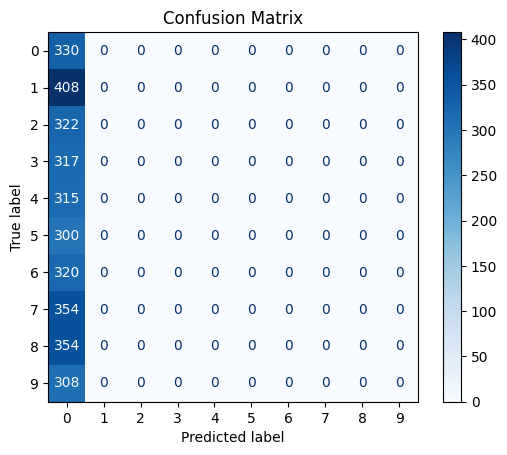

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val_true_classes, y_val_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [46]:
X_test = df_test.values

X_test = X_test / 255.0
X_test = X_test.reshape(-1, 28, 28, 1)
y_final_pred = best_model.predict(X_test)
y_final_pred_classes = np.argmax(y_final_pred, axis=1)

521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step


In [47]:
list(sample_submission)

['ImageId', 'Label']

In [48]:
submission = pd.DataFrame({
    'ImageId': np.arange(1, len(y_final_pred_classes) + 1),
    'Label': y_final_pred_classes
})

submission.to_csv('submission.csv', index=False)

print("Results have been saved to 'submission.csv'")

Results have been saved to 'submission.csv'


Training SVM model...
[LibSVM]
Validation accuracy: 0.9660

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        94
           1       0.99      0.99      0.99       137
           2       0.95      0.95      0.95        84
           3       0.93      0.96      0.95       101
           4       0.97      0.98      0.97        95
           5       0.98      0.93      0.95        96
           6       0.98      0.98      0.98        99
           7       0.97      0.95      0.96       108
           8       0.95      0.97      0.96        98
           9       0.93      0.95      0.94        88

    accuracy                           0.97      1000
   macro avg       0.96      0.97      0.96      1000
weighted avg       0.97      0.97      0.97      1000



<Figure size 1000x800 with 0 Axes>

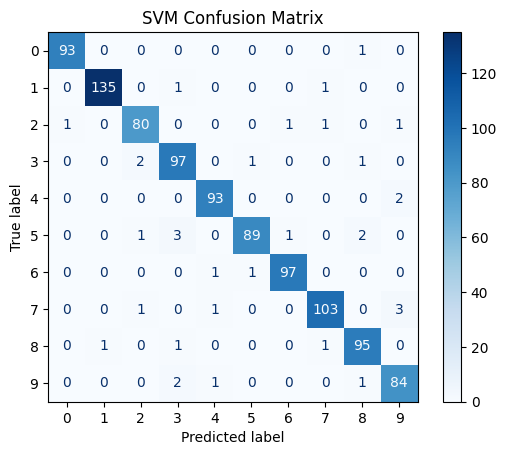

Making predictions on test set...
Results have been saved to 'submission_svm.csv'


In [51]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# First, let's prepare the data for SVM
# We need to flatten the images from (samples, 28, 28, 1) to (samples, 784)
# We'll use the original X and y before one-hot encoding

# Get original data
X = df_train.drop('label', axis=1).to_numpy()
y = df_train['label'].to_numpy()

# Normalize the pixel values [0, 255] -> [0, 1]
X = X / 255.0

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')  # Using mean imputation
X = imputer.fit_transform(X)

# Split the data
X_train_svm, X_val_svm, y_train_svm, y_val_svm = train_test_split(X, y, test_size=0.2, random_state=42)

# Due to computational constraints, we'll use a subset of the data
# SVM can be slow on large datasets
train_size = 10000  # Using first 10000 samples
X_train_subset = X_train_svm[:train_size]
y_train_subset = y_train_svm[:train_size]
X_val_subset = X_val_svm[:1000]  # Using 1000 samples for validation
y_val_subset = y_val_svm[:1000]

# Create and train SVM model
print("Training SVM model...")
svm_model = SVC(kernel='rbf', random_state=42, verbose=True)
svm_model.fit(X_train_subset, y_train_subset)

# Make predictions on validation set
y_val_pred_svm = svm_model.predict(X_val_subset)

# Calculate accuracy
svm_accuracy = accuracy_score(y_val_subset, y_val_pred_svm)
print(f"\nValidation accuracy: {svm_accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_val_subset, y_val_pred_svm))

# Create confusion matrix
cm_svm = confusion_matrix(y_val_subset, y_val_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=[str(i) for i in range(10)])
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.show()

# If you want to make predictions on the test set and create a submission
print("Making predictions on test set...")
X_test_svm = X_test.reshape(X_test.shape[0], -1)  # Flatten test data
X_test_svm = imputer.transform(X_test_svm)  # Use the same imputer from training
y_test_pred_svm = svm_model.predict(X_test_svm)

# Create submission DataFrame
submission_svm = pd.DataFrame({
    'ImageId': np.arange(1, len(y_test_pred_svm) + 1),
    'Label': y_test_pred_svm
})

# Save predictions
submission_svm.to_csv('submission_svm.csv', index=False)
print("Results have been saved to 'submission_svm.csv'")


In [52]:

# Print comparison
print("\nModel Accuracy Comparison:")
print("-" * 30)
print(f"CNN Accuracy: {cnn_test_accuracy:.4f}")
print(f"SVM Accuracy: {svm_accuracy:.4f}")



Model Accuracy Comparison:
------------------------------
CNN Accuracy: 0.0992
SVM Accuracy: 0.9660


Training Decision Tree model...

Validation accuracy: 0.8280

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       196
           1       0.93      0.93      0.93       247
           2       0.78      0.83      0.80       185
           3       0.78      0.83      0.80       192
           4       0.78      0.80      0.79       192
           5       0.73      0.74      0.74       188
           6       0.87      0.85      0.86       194
           7       0.89      0.86      0.87       215
           8       0.81      0.75      0.78       216
           9       0.78      0.81      0.79       175

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.82      2000
weighted avg       0.83      0.83      0.83      2000



<Figure size 1000x800 with 0 Axes>

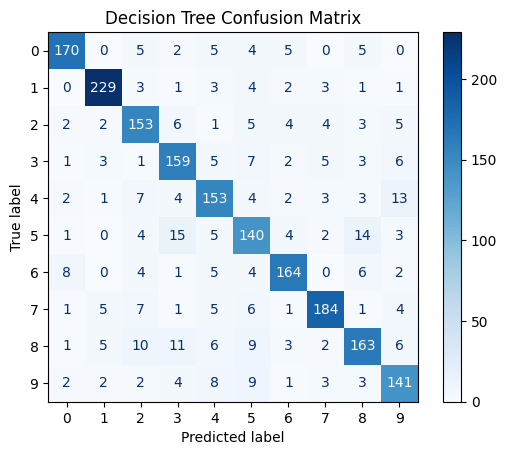

Making predictions on test set...
Results have been saved to 'submission_dt.csv'

Top 10 Most Important Features:
     feature  importance
434      434    0.061439
409      409    0.050123
155      155    0.047363
657      657    0.046202
239      239    0.043861
432      432    0.035879
375      375    0.031087
271      271    0.030061
296      296    0.029380
488      488    0.028360


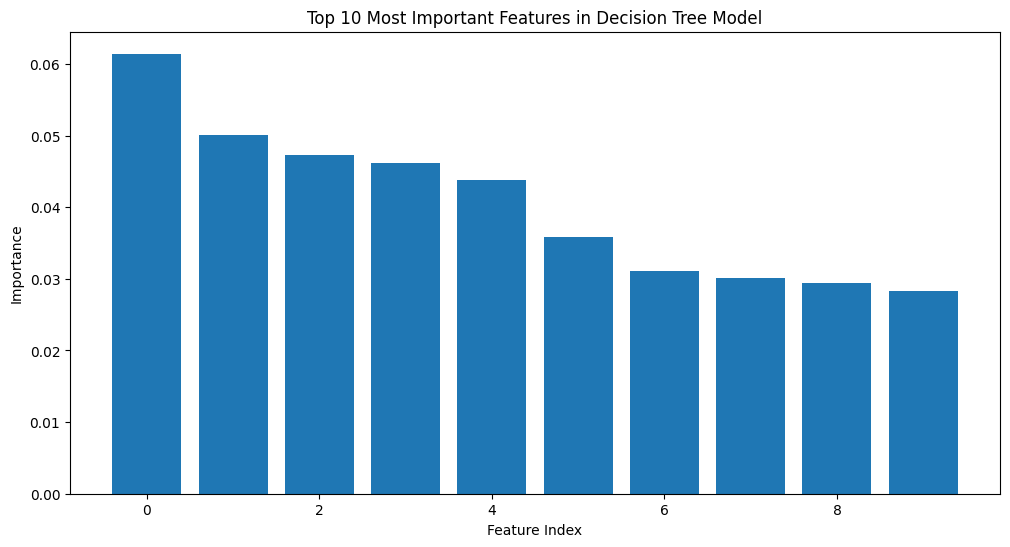

In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# First, let's prepare the data for Decision Tree
# We'll use the same data preparation as SVM since Decision Trees can also work with flattened images

# Get original data
X = df_train.drop('label', axis=1).to_numpy()
y = df_train['label'].to_numpy()

# Normalize the pixel values [0, 255] -> [0, 1]
X = X / 255.0

# Split the data
X_train_dt, X_val_dt, y_train_dt, y_val_dt = train_test_split(X, y, test_size=0.2, random_state=42)

# Unlike SVM, Decision Trees can handle larger datasets more efficiently
# But we can still use a subset if needed for faster training
train_size = 20000  # Using more samples than SVM as Decision Trees are faster
X_train_subset = X_train_dt[:train_size]
y_train_subset = y_train_dt[:train_size]
X_val_subset = X_val_dt[:2000]  # Using 2000 samples for validation
y_val_subset = y_val_dt[:2000]

# Create and train Decision Tree model
print("Training Decision Tree model...")
dt_model = DecisionTreeClassifier(
    max_depth=20,          # Prevent overfitting
    min_samples_split=10,  # Minimum samples required to split an internal node
    min_samples_leaf=5,    # Minimum samples required to be at a leaf node
    random_state=42
)

# Train the model
dt_model.fit(X_train_subset, y_train_subset)

# Make predictions on validation set
y_val_pred_dt = dt_model.predict(X_val_subset)

# Calculate accuracy
dt_accuracy = accuracy_score(y_val_subset, y_val_pred_dt)
print(f"\nValidation accuracy: {dt_accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_val_subset, y_val_pred_dt))

# Create confusion matrix
cm_dt = confusion_matrix(y_val_subset, y_val_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=[str(i) for i in range(10)])
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.show()

# Make predictions on test set and create submission
print("Making predictions on test set...")
X_test_dt = X_test.reshape(X_test.shape[0], -1)  # Flatten test data
y_test_pred_dt = dt_model.predict(X_test_dt)

# Create submission DataFrame
submission_dt = pd.DataFrame({
    'ImageId': np.arange(1, len(y_test_pred_dt) + 1),
    'Label': y_test_pred_dt
})

# Save predictions
submission_dt.to_csv('submission_dt.csv', index=False)
print("Results have been saved to 'submission_dt.csv'")

# Print feature importance (additional insight for Decision Trees)
feature_importance = pd.DataFrame({
    'feature': range(X.shape[1]),
    'importance': dt_model.feature_importances_
})
top_features = feature_importance.nlargest(10, 'importance')
print("\nTop 10 Most Important Features:")
print(top_features)

# Visualize feature importance
plt.figure(figsize=(12, 6))
plt.bar(range(10), top_features['importance'])
plt.title('Top 10 Most Important Features in Decision Tree Model')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.show()


In [55]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=3,
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit the grid search
print("Performing grid search for Decision Tree hyperparameters...")
grid_search.fit(X_train_subset, y_train_subset)

# Print best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Use the best model for predictions
best_dt_model = grid_search.best_estimator_


Performing grid search for Decision Tree hyperparameters...
Fitting 3 folds for each of 54 candidates, totalling 162 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 15}
Best cross-validation score: 0.8097


In [56]:
# Print comparison
print("\nModel Accuracy Comparison:")
print("-" * 30)
print(f"CNN Accuracy: {cnn_test_accuracy:.4f}")
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")


Model Accuracy Comparison:
------------------------------
CNN Accuracy: 0.0992
SVM Accuracy: 0.9660
Decision Tree Accuracy: 0.8280
